In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from Bio import AlignIO
# from Bio.Alphabet import IUPAC, Gapped
from Bio.Align import MultipleSeqAlignment as MSA
import math

#### Color-coded MSA in Fig. 6D

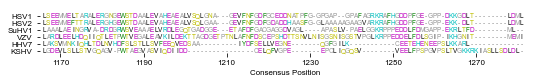

In [18]:
align = AlignIO.read('../Alignment Files/DBP_HHV-subset_homologs_hits_alignment.aln', 'clustal')

ids = []
seqs = []
for line in align:
    ids.append(line.id.split('|')[1])
    seqs.append(line.seq[1166:])
ids.reverse()
seqs.reverse()
msa = dict(zip(ids, seqs))
xvals = range(len(seqs[0]))
ydummy = np.linspace(0, len(ids), len(xvals))
yvals = range(len(ids))
yvir = dict(zip(yvals, ids))

typeDict = {'A':'-', 'C':'-', 'D':'acidic', 'E':'acidic', 'F':'aromatic', 'G':'-', 'H':'basic', 'I':'non-polar',
            'K':'basic', 'L':'non-polar', 'M':'-', 'N':'polar', 'P':'-', 'Q':'polar', 'R':'basic', 'S':'polar',
            'T':'polar', 'V':'non-polar', 'W':'aromatic', 'Y':'aromatic', '-':'-'}

colorDict = {'-':'#999999', 'acidic':'m', 'basic':'c', 'non-polar':'k', 'polar':'y', 'aromatic':'g'}

fig, ax = plt.subplots(1, 1, figsize=(7.5,1.2))
ax.plot(xvals, ydummy, alpha=0)

for y in yvals:
    for x in xvals:
        res = msa[yvir[y]][x]
        ax.annotate(xy=(x, y), text=res, ha='center', va='center', color=colorDict[typeDict[res]], fontsize=6.5)
sns.despine(left=True, bottom=True)
xticks = [0, 20, 40, 60, 80, 100]
ax.set_xticks([x + 4 for x in xticks])
ax.set_xticklabels([x + 1170 for x in xticks])
ax.set_xlim(-1, 117)
ax.set_xlabel('Consensus Position')
ax.set_yticks(yvals)
ax.set_yticklabels(ids)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure 6/DBP_hits_MSA_C-terminus.png', dpi=1200)


### Process perturbation screen for modified tiling plots below

In [2]:
font = {'family' : 'Arial',
        'size'   : 8}

matplotlib.rc('font', **font)

WT_A = 0.21506548936633008
WT_R = 0.17315610959701574
orig_cutoffA = 1.0846347878236864
orig_cutoffR = 0.6987727639587653

# filter out library members with too few reads, add meta data about perturbation type, and calculate hits threshold
# screen_type should be 'Act' or 'Rep'
def process_screen(df, screen_type, sigma, counts_filter):
    df['countsSUM_R1'] = df['countsON_R1'] + df['countsOFF_R1']
    df['countsSUM_R2'] = df['countsON_R2'] + df['countsOFF_R2']
    df = df[(df['countsSUM_R1']>=counts_filter) & (df['countsSUM_R2']>=counts_filter)]
    
    df = df.rename(columns={'label':'Oligo ID'})
    df['Type'] = np.where(df['Oligo ID'].str.contains('random'), 'random', 'substitution')
    df['Type'] = np.where(df['Oligo ID'].str.contains('del5'), 'deletion', df['Type'])
    df['Type'] = np.where(df['Oligo ID'].str.contains('fiducial'), 'fiducial', df['Type'])
    df['Type'] = np.where(df['Oligo ID'].str.contains('_WT'), 'WT', df['Type'])
    
    if screen_type == 'Act':
        df['R1'] = -df['R1']
        df['R2'] = -df['R2']
        df['Avg'] = -df['Avg']
        
    rand = list(df[df['Type']=='random']['Avg'])
    thresh = np.mean(rand) + sigma*np.std(rand)
    df['Hit'] = np.where(df['Avg']>=thresh, 1, 0)
    
    return df, thresh

# add additional information, including fiducial details, WT tile effect, and other meta data
# IMPORTANT: all mutations are off by +1, so this code corrects for that
def add_info(df, fiducials, maxTiles, prot_seqs):
    # merge in fiducial information and protein sequences
    df['Full Tile ID'] = df['Oligo ID'].str.split('_').str[1:].str.join('_')
    df = pd.merge(df, fiducials[['Full Tile ID', 'Gene', 'Effect']], on='Full Tile ID', how='left')
    df = pd.merge(df, prot_seqs, on='Full Tile ID', how='left')
    df['Effect'] = np.where(df['Effect'].isnull(), '-', df['Effect'])
    df['Tile ID'] = np.where(~df['Full Tile ID'].str.contains('fiducial|random'), df['Full Tile ID'].str.split('_').str[:-1].str.join('_'), '-')
    df['Mutation'] = np.where(~df['Full Tile ID'].str.contains('fiducial|random'), df['Full Tile ID'].str.split('_').str[-1], '-')
    
    # isolate mutations and position information
    df['Original'] = np.where(df['Type'].isin(['substitution', 'deletion']), df['Mutation'].str[0], '-')
    df['Position'] = np.where(df['Type']=='substitution', df['Mutation'].str[1:-1], '-')
    df['Perturbation'] = np.where(df['Type']=='substitution', df['Mutation'].str[-1], '-')
    df['Position'] = np.where(df['Type']=='deletion', df['Mutation'].str[1:-4], df['Position'])
    df['Perturbation'] = np.where(df['Type']=='deletion', 'del5', df['Perturbation'])
    df['Position'] = [int(p) - 1 if p!='-' else '-' for p in list(df['Position'])]
    
    # correct mutation position in the 'Mutation', 'Full Tile ID', and 'Oligo ID' fields
    df['Mutation'] = np.where(df['Type'].isin(['substitution', 'deletion']), df['Original'] + df['Position'].astype(str) + df['Perturbation'], df['Mutation'])
    df['Full Tile ID'] = np.where(df['Type'].isin(['substitution', 'deletion']), df['Tile ID'] + '_' + df['Mutation'], df['Full Tile ID'])
    df['Oligo ID'] = np.where(df['Type'].isin(['substitution', 'deletion']), 'HHV-DMS_' + df['Full Tile ID'], df['Oligo ID'])
    
    df = pd.merge(df, maxTiles, on='Tile ID', how='outer')
    df['Effect'] = np.where(df['Effect_y'].isnull(), df['Effect_x'], df['Effect_y'])
    
    # fill in information for F5HCV3_060
    df['Tile Start'] = np.where(df['Tile ID']=='F5HCV3_060', 591, df['Tile Start'])
    df['Tile End'] = np.where(df['Tile ID']=='F5HCV3_060', 670, df['Tile End'])
    df['Protein'] = np.where(df['Tile ID']=='F5HCV3_060', 'RTA', df['Protein'])
    df['Virus Abbreviation'] = np.where(df['Tile ID']=='F5HCV3_060', 'KSHV', df['Virus Abbreviation'])
    df['Effect'] = np.where(df['Tile ID']=='F5HCV3_060', 'activator', df['Effect'])
    df = df.drop(columns=['Effect_x', 'Effect_y', 'Gene'])
    
    return df

# read in necessary files as dataframes: screen scores, fiducials, and details on original WT max tiles
Act = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ActivD2_combo.csv', sep=',')
Rep = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ReprD5_combo.csv', sep=',')

fiducials = pd.read_csv('../Supplemental Tables - CSV/fiducial_controls.csv', sep=',').drop(columns='Unnamed: 0')
fiducials['Number'] = fiducials.index + 1
fiducials['Full Tile ID'] = 'fiducial_' + fiducials['Number'].astype(str).str.zfill(3)
fiducials['Effect'] = np.where(fiducials['Description'].str.contains('Repr'), 'repressor', 'activator')
fiducials['Effect'] = np.where(fiducials['label'].str.contains('random'), '-', fiducials['Effect'])

maxTiles = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV-perturb_max-tiles.csv')
maxTiles['Effect'] = np.where((maxTiles['Activation']>=orig_cutoffA), 'activator', '-')
maxTiles['Effect'] = np.where((maxTiles['Repression']>=orig_cutoffR), 'repressor', maxTiles['Effect'])
maxTiles['Effect'] = np.where((maxTiles['Activation']>=orig_cutoffA) & (maxTiles['Repression']>=orig_cutoffR), 'dual', maxTiles['Effect'])
maxTiles = maxTiles[['Tile ID', 'Tile Start', 'Tile End', 'Effect', 'Protein', 'Virus Abbreviation']]

prot_seqs = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV_Hits_DMS_codon-opt-proteins_oligos.csv')
prot_seqs = prot_seqs[['Name', 'Protein Sequence']].rename(columns={'Name':'Full Tile ID'})

# process files
Act, threshA = process_screen(Act, 'Act', 2, 50)
Act = add_info(Act, fiducials, maxTiles, prot_seqs)
# Act.to_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ActivD2_combo_expanded.csv', index=False)

Rep, threshR = process_screen(Rep, 'Rep', 2, 50)
Rep = add_info(Rep, fiducials, maxTiles, prot_seqs)
# Rep.to_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ReprD5_combo_expanded.csv', index=False)

print('Activation threshold: %s' % str(threshA))
print('Repression threshold: %s' % str(threshR))
print('Complete')

Activation threshold: -1.393846406032031
Repression threshold: -1.071410423724703
Complete


### Modified perturbation tiling plots for DBP

#### KSHV DBP featured in Fig. 6E, other homologs in Fig. S7D-G

In [4]:
import os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

font = {'family' : 'Arial',
        'size'   : 8}

matplotlib.rc('font', **font)

jpred4 = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/jpred4_results_summarized.csv').drop(columns='Protein Sequence')
dropoutDict = {'P12978_010':'PPPPPPPPPPQRRDAWTQEPSPLDRDPLGYDVGHGPLASAMRMLWMANYIVRQSRGDRGLILPQGPQTAPQARLVQPHVP',
               'P52351_041':'TKKKKRYREDDDRELTKDKNDIKELVDAIGMLRHEISALKYIRSQSPQRQHCTAVDTMPTIEEKNVASPKPSVVNASLTP'}
coords = {'P12978_010':[91, 170], 'P52351_041':[401, 480]}

# generate tiling plots containing all info and sequence
def tiling_plot(df, tile, label, effect_type, thresh, structure, savedir):
    # set variables based on effect type
    if effect_type == 'activator':
        color = '#D7AC00'
        ylabel = 'log$_2$(ON:OFF)\nActivation Score'
        sigma2 = 2*WT_A
        
    elif effect_type == 'repressor':
        color = '#23BEDB'
        ylabel = 'log$_2$(OFF:ON)\nRepression Score'
        sigma2 = 2*WT_R
    
    # check if output directory exists - if not, make directory
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    
    # subset dataframe to focus on those with correct activity, determine y-limits, and get list of tile identifiers
    df = pd.merge(df, structure, on='Tile ID', how='left')
    df = df[df['Effect'].isin([effect_type, 'dual'])]
    tileList = [tile]
    ymax=3
    ymin=-3
    
    # for each tile, create plot with effect of all perturbations
    for tile in tileList:
        tempdf = df[df['Tile ID']==tile]
        if 'WT' not in list(tempdf['Type']):
            virus = list(tempdf['Virus Abbreviation'])[0]
            protein = list(tempdf['Protein'])[0]
            print('No WT measurement for %s %s (%s)' % (virus, protein, tile))
            WT_seq = dropoutDict[tile]
            WT_struct = ''.join(['-']*80)
            print(WT_struct)
            start = coords[tile][0]
            end = coords[tile][1] + 1
            
        else:
            # extract information about WT sequence: virus, protein, scores for each replicate, sequence, and coordinates
            virus = list(tempdf[tempdf['Type']=='WT']['Virus Abbreviation'])[0]
            protein = list(tempdf[tempdf['Type']=='WT']['Protein'])[0]
            WT_avg = list(tempdf[tempdf['Type']=='WT']['Avg'])[0]
            WT_vals = [WT_avg + sigma2, WT_avg - sigma2]
            WT_seq = list(tempdf[tempdf['Type']=='WT']['Protein Sequence'])[0]
            WT_struct = list(tempdf[tempdf['Type']=='WT']['Structure'])[0]
            start = int(list(tempdf[tempdf['Type']=='WT']['Tile Start'])[0])
            end = int(list(tempdf[tempdf['Type']=='WT']['Tile End'])[0]) + 1
        xticks = list(range(start, end, 1))
        xticks_mod = [x - 0.5 for x in xticks]
        xrange = list(range(start, end+1, 5))
        
        # create dataframes for specific subplots
        struct_dict = {'-':'#FFFFFF', 'E':'#555555', 'H':'#AAAAAA'}
        WT_struct = [struct_dict[s] for s in WT_struct if s in struct_dict]
        struct_df = pd.DataFrame(index=xticks, data={'JPred4':list(WT_struct)}).T
        
        deletion = tempdf[tempdf['Type']=='deletion']
        deletion = deletion.sort_values(by='Position')
        delx = [p + 2 for p in list(deletion['Position'])]
        dely = list(deletion['Avg'])
        delyerr = list(deletion['Standard Error'])
        
        subs = tempdf[tempdf['Type']=='substitution']
        subs = subs.sort_values(by='Position')
        subx = list(subs['Position'])
        suby = list(subs['Avg'])
        subyerr = list(subs['Standard Error'])
        subaa = list(subs['Perturbation'])
        sub_nonhit = list(subs[subs['Hit']==0]['Position'])
        
        # initialize plots
        fig, ax = plt.subplots(3, 1, figsize=(8.4,1.8), gridspec_kw={'height_ratios':[1.25, 2.75, 16]}, sharex=False)
        plt.subplots_adjust(hspace=0.05)
        
        ax[0].set_xlim(xrange[0]-0.5, xrange[-1]-0.5)
        ax[0].set_xticks([])
        ax[0].set_ylim(1,2)
        ax[0].set_yticks([])
        ax[0].set_ylabel('', rotation=0, va='center', ha='right')
        ax[0].set_title('%s (%s)' % (label, tile), fontsize=8)
        sns.despine(left=True, bottom=True, ax=ax[0])
        for s, x in zip(list(WT_struct), xticks_mod):
            ax[0].add_patch(Rectangle((x, 1), 1, 1, edgecolor=s, facecolor=s))
            
        custom_patch = [Line2D([0], [0], color='#AAAAAA', marker='s', lw=0),
                        Line2D([0], [0], color='#555555', marker='s', lw=0)]
        ax[0].legend(custom_patch, ['Helix', 'Beta      '], loc='upper right',
                     bbox_to_anchor=(0, 2), frameon=False, handletextpad=-0.2,
                     labelspacing=0.1, borderpad=0, title='JPred4', title_fontsize=8)
             
        # plot sequence on top with critical substitutions highlighted
        ax[1].set_xlim(xrange[0]-0.5, xrange[-1]-0.5)
        ax[1].xaxis.set_major_locator(MultipleLocator(5))
        ax[1].xaxis.set_minor_locator(MultipleLocator(1))
        ax[1].xaxis.set_ticklabels('')
        ax[1].set_ylim(0,2)
        ax[1].set_yticks([])
        sns.despine(left=True, bottom=True, ax=ax[1])
        
        for x, aa in zip(xticks, WT_seq):
            if x in sub_nonhit:
                ax[1].annotate(text=aa, xy=(x, 1), va='center', ha='center', size=7, color='#EA7063')
            else:
                ax[1].annotate(text=aa, xy=(x, 1), va='center', ha='center', size=7)
                
        # plot deletion scan data, with WT scores as horizontal span
        ax[2].set_xlim(xrange[0]-0.5, xrange[-1]-0.5)
        ax[2].xaxis.set_major_locator(MultipleLocator(5))
        ax[2].xaxis.set_minor_locator(MultipleLocator(1))
        ax[2].set_ylim(ymin, ymax)
        ax[2].axhline(y=thresh, color='#333333', ls=':', zorder=-5, lw=1)
        if 'WT' in list(tempdf['Type']):
            ax[2].axhspan(ymax=WT_vals[0], ymin=WT_vals[1], color=color, alpha=0.25, zorder=-2)
            ax[2].axhline(y=WT_avg, color=color, ls=':', zorder=-1, lw=1)
        
        for x in xrange:
            ax[2].axvline(x=x-0.5, color='#DDDDDD', ls=':', lw=1)
        
        plotdf_del = pd.DataFrame({'X':delx, 'Y':dely})
        sns.scatterplot(data=plotdf_del, x='X', y='Y', color=color, ax=ax[2], linewidth=0)
        for x, y, ye in zip(delx, dely, delyerr):
            ax[2].errorbar(x, y, xerr=2.5, yerr=ye, color=color, zorder=100)
        
        # plot substitution data
        for x, y, aa in zip(subx, suby, subaa):
            ax[2].annotate(text=aa, xy=(x, y), va='center', ha='center', size=7, color=color)
        
        ax[2].set_xlabel('Position along Protein')
#         ax[2].set_xlabel('Residue Position along %s (%s)' % (label, tile))
        ax[2].set_ylabel(ylabel)
        
        savename = '_'.join([virus, protein, tile, effect_type, 'perturb.png'])
#         plt.title(title)
        plt.savefig(os.path.join(savedir, savename), dpi=1200, bbox_inches='tight', transparent=True)
        plt.close()
        
savedir_main = '../Individual Figure Panels/Figure 6'
savedir_supp = '../Individual Figure Panels/Figure S7'

tiling_plot(Act, 'Q2HRD3_107', 'KSHV DBP', 'activator', threshA, jpred4, savedir_main)
tiling_plot(Act, 'P04296_109', 'HSV1 DBP', 'activator', threshA, jpred4, savedir_supp)
tiling_plot(Act, 'P52339_106', 'HHV7 DBP', 'activator', threshA, jpred4, savedir_supp)
tiling_plot(Rep, 'P52339_106', 'HHV7 DBP', 'repressor', threshR, jpred4, savedir_supp)
tiling_plot(Act, 'P36384_109', 'HSV2 DBP', 'activator', threshA, jpred4, savedir_supp)
print('Complete')

Complete


### Late gene reactivation and replication quantification

#### Barplots featured in Fig. 6H

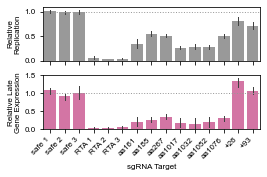

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

keep = ['VS_1', 'VS_2', 'VS_3', '50_1', '50_2', '50_3', '161', '185', '267', '1017', '1032', '1052', '1076', '+26', '+93']
rename = ['safe 1', 'safe 2', 'safe 3', 'RTA 1', 'RTA 2', 'RTA 3', 'aa161', 'aa185', 'aa267', 'aa1017', 'aa1032',
          'aa1052', 'aa1076', '+26', '+93']

normLG = pd.read_csv('../Supplemental Tables - CSV/DM_KSHV_ORF6_late-gene-summary_0603_reformat-normalized.csv').dropna()
long = []
for col in normLG.columns:
    if 'rep' in col:
        tempdf = normLG[['Label', col]].rename(columns={col:'Norm. Fraction'})
        tempdf['Replicate'] = col[-1]
        long.append(tempdf)
LGlong = pd.concat(long).reset_index(drop=True)
LGlong = LGlong[LGlong['Label'].isin(keep)]
LGlong['Label'] = pd.Categorical(LGlong['Label'], categories=keep, ordered=True)
LGlong = LGlong.sort_values(by='Label')

normEdu = pd.read_csv('../Supplemental Tables - CSV/DM_KSHV_ORF6_edu-summary-20220526_normalized.csv').dropna()
long = []
for col in normEdu.columns:
    if 'Rep' in col:
        tempdf = normEdu[['Label', col]].rename(columns={col:'Norm. Fraction'})
        tempdf['Replicate'] = col[-1]
        long.append(tempdf)
Edulong = pd.concat(long).reset_index(drop=True)
Edulong = Edulong[Edulong['Label'].isin(keep)]
Edulong['Label'] = pd.Categorical(Edulong['Label'], categories=keep, ordered=True)
Edulong = Edulong.sort_values(by='Label')

fig, ax = plt.subplots(2, 1, figsize=(3.75, 2.5))
sns.barplot(data=Edulong, x='Label', y='Norm. Fraction', errwidth=1, ax=ax[0], color='#999999')
ax[0].axhline(y=1, ls=':', lw=1, color='#999999')
ax[0].set_xticks(ticks=range(len(rename)))
ax[0].set_xticklabels([])
ax[0].set_xlabel('')
ax[0].set_ylabel('Relative\nReplication')

sns.barplot(data=LGlong, x='Label', y='Norm. Fraction', errwidth=1, ax=ax[1], color='#e266a4')
ax[1].axhline(y=1, ls=':', lw=1, color='#999999')
ax[1].set_xticks(ticks=range(len(rename)))
ax[1].set_xticklabels(labels=rename, rotation=45, ha='right')
ax[1].set_xlabel('sgRNA Target')
ax[1].set_ylabel('Relative Late\nGene Expression')
ax[1].set_ylim(0, 1.5)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure 6/KSHV_DBP_replication_late-gene-expression_barplot.png', dpi=1200)
# plt.xticks(rotation=45, ha='right', ticks=range(len(rename)), labels=rename)

### p300 inhibition of KSHV DBP

In [19]:
df = pd.read_csv('../Flow Single-Cell Data - CSV/HHVhits_chem-inhib_Screen_validations_single-cell.csv')
df = df[(df['P1']==True) & (df['P2']==True) & (df['mCherry']==True)]
df = df.rename(columns={'Citrine':'Citrine_Act'})
df['Citrine_Rep'] = np.where(df['mCitrine-A']>1e7, True, False)
df.loc[df['Protein'].isna(), 'Protein'] = 'empty' 
df = df.replace(to_replace='taz', value='tazemetostat')

aggdf = df.groupby(by=['Reporter', 'Condition', 'Treatment', 'Construct', 'Protein', 'Replicate', 'Time'], as_index=False).mean()
aggdf = aggdf.replace(to_replace='taz', value='tazemetostat')

key = pd.read_csv('../Flow Single-Cell Data - CSV/HHV-chem-inhib_validations_key.csv')

print('Complete')

Complete


In [20]:
constructDict = {'CL144':['Human', 'MYBA', '', ''],
                 'JT151':['Human', 'KRAB', '', ''],
                 'JT126':['', 'empty', '', '']}

info = pd.read_csv('../Supplemental Tables - CSV/HHVhits_added-info.csv')
infoA = info.drop(columns='Repression').rename(columns={'Activation':'Avg'})
infoA['Screen'] = 'Activation'
infoR = info.drop(columns='Activation').rename(columns={'Repression':'Avg'})
infoR['Screen'] = 'Repression'
info = pd.concat([infoA, infoR])

key = pd.read_csv('../Flow Single-Cell Data - CSV/HHV-chem-inhib_validations_key.csv')
key = key[['Construct', 'Tile_ID']].rename(columns={'Tile_ID':'Tile ID'})
key = pd.merge(key, info, on='Tile ID', how='left')

for i in constructDict:
    key.loc[key['Construct']==i, 'Virus Abbreviation'] = constructDict[i][0]
    key.loc[key['Construct']==i, 'Protein'] = constructDict[i][1]
    key.loc[key['Construct']==i, 'Tile Start'] = constructDict[i][2]
    key.loc[key['Construct']==i, 'Tile End'] = constructDict[i][3]

aggdfA = aggdf[aggdf['Reporter']=='DY032']
aggdfA = aggdfA[['Construct', 'Condition', 'Treatment', 'Replicate', 'Citrine_Act']]
aggdfA['Citrine OFF'] = 1 - aggdfA['Citrine_Act']  

normdf = aggdfA[aggdfA['Condition']=='dox']
normdf['Citrine ON'] = normdf['Citrine_Act']*100
normdf = normdf.groupby(by=['Construct', 'Treatment'])['Citrine ON'].agg(['mean', 'std']).reset_index()
normdf = normdf.rename(columns={'mean':'Citrine ON', 'std':'ON std'})
keyA = pd.merge(key[key['Screen']=='Activation'], normdf, on='Construct', how='left').drop_duplicates(subset=['Treatment', 'Tile ID', 'Screen'])

aggdfR = aggdf[aggdf['Reporter']=='JT039']
aggdfR = aggdfR[['Construct', 'Condition', 'Treatment', 'Replicate', 'Citrine_Rep']]
aggdfR['Citrine OFF'] = 1 - aggdfR['Citrine_Rep']

normdf = aggdfR[aggdfR['Condition']=='dox']
normdf['Citrine OFF'] = normdf['Citrine OFF']*100
normdf = normdf.groupby(by=['Construct', 'Treatment'])['Citrine OFF'].agg(['mean', 'std']).reset_index()
normdf = normdf.rename(columns={'mean':'Citrine OFF', 'std':'OFF std'})

keyR = pd.merge(key[key['Screen']=='Repression'], normdf, on='Construct', how='left').drop_duplicates(subset=['Treatment', 'Tile ID', 'Screen'])
print('Complete')

Complete


<ipython-input-20-ec103506e8db>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normdf['Citrine ON'] = normdf['Citrine_Act']*100
<ipython-input-20-ec103506e8db>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normdf['Citrine OFF'] = normdf['Citrine OFF']*100


#### Flow plots featured in Fig. 6F

In [36]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

def plot_validations_subset(df, screentype, key, protein):
    if screentype == 'Activation':
        reporter = 'DY032'
        color = '#F3CE48'
        yvar = 'Citrine ON'
        opposite = 'Repression'
        cutoff = 3e6
    elif screentype == 'Repression':
        reporter = 'JT039'
        color = '#23BEDB'
        yvar = 'Citrine OFF'
        opposite = 'Activation'
        cutoff = 1e7
    
    df = df[(df['Reporter']==reporter) & (df['Protein']==protein)]
    df['mCitrine'] = np.log10(df['mCitrine-A'])
    df = df.drop(columns='Protein')
    df = pd.merge(df, key[['Construct', 'Treatment', 'Avg', 'Virus Abbreviation', 'Protein', 'Tile Start', 'Tile End', yvar, 'Screen']], how='left', on=['Construct', 'Treatment'])
    df.loc[df['Avg'].isna(), 'Avg'] = -10
    df['Condition'] = pd.Categorical(df['Condition'], categories=['nodox', 'dox'], ordered=True)
    df = df.sort_values(by=['Avg', 'Condition', 'Replicate'], ascending=[False, True, True])
    df['Condition-Replicate'] = df['Condition'].astype(str) + '-' + df['Replicate']
    
    labeldf = df[df['Screen']!=opposite].sort_values(by=['Avg'], ascending=False)
    labeldf = labeldf[['Construct', 'Virus Abbreviation', 'Protein', 'Treatment', 'Tile Start', 'Tile End', yvar, 'Avg']].drop_duplicates(subset=['Construct', 'Treatment'])
    labeldf['Tile Start'] = np.where(labeldf['Tile Start']=='', labeldf['Tile Start'], labeldf['Tile Start'].astype(str).str.split('.').str[0])
    labeldf['Tile End'] = np.where(labeldf['Tile End']=='', labeldf['Tile End'], labeldf['Tile End'].astype(str).str.split('.').str[0])
    labeldf['Sample'] = np.where(labeldf['Tile Start']=='', labeldf['Virus Abbreviation'] + ' ' + labeldf['Protein'],
                             labeldf['Virus Abbreviation'] + ' ' + labeldf['Protein'] + '\n[' \
                             + labeldf['Tile Start'] + '-' + labeldf['Tile End'] + ']\n' + labeldf['Treatment'])
    labeldf['Construct-Treatment'] = labeldf['Construct'] + '_' + labeldf['Treatment']

    df['Construct-Treatment'] = df['Construct'] + '_' + df['Treatment']
    samples = dict(zip(list(labeldf['Construct-Treatment']), list(labeldf['Sample'])))
    df['Sample'] = df['Construct-Treatment'].map(samples)
    txorder = list(set(list(df['Treatment'])))
    txorder.sort(reverse=True)
    txorder = ['DMSO'] + [t for t in txorder if t != 'DMSO']
    df['Treatment'] = pd.Categorical(df['Treatment'], categories=txorder, ordered=True)
    df = df.sort_values(by='Treatment')
    labeldf['Treatment'] = pd.Categorical(labeldf['Treatment'], categories=txorder, ordered=True)
    labeldf = labeldf.sort_values(by='Treatment')
    df = df[df['Screen']!=opposite].sort_values(by=['Construct', 'Condition', 'Replicate'])
    
    if screentype == 'Activation':
        ON = list(labeldf[yvar])
        ON = [round(on, 1) for on in ON]
        OFF = [str(round(100-on, 1)) + '%' for on in ON]
        ON = [str(on) + '%' for on in ON]
        
    elif screentype == 'Repression':
        OFF = list(labeldf[yvar])
        OFF = [round(off, 1) for off in OFF]
        ON = [str(round(100-off, 1)) + '%' for off in OFF]
        OFF = [str(off) + '%' for off in OFF]
        
    pal = sns.color_palette(['#999999', '#999999', color, color])
    if len(df) == 0:
        return None
    
    g = sns.FacetGrid(data=df, row='Treatment',
                      hue='Condition-Replicate', palette=pal,
                      aspect=1.45, height=1)
    g.map(sns.kdeplot, 'mCitrine', fill=True, bw_adjust=0.2)
    g.map(plt.axvline, x=np.log10(cutoff), ls=':', color='#333333', lw=1)
    g.set_titles(template='{row_name}')
    plt.xlim([4.5,9.5])
    plt.xlabel('mCitrine')
    plt.ylim([0,4.5])
    plt.xticks([5, 6, 7, 8, 9], ['10$^5$', '10$^6$', '10$^7$', '10$^8$', '10$^9$'])
    for ax, on, off in zip(g.axes.flat, ON, OFF):
        ax.text(0.05, 0.95, off, transform=ax.transAxes, ha='left', va='top')
        ax.text(0.95, 0.95, on, transform=ax.transAxes, ha='right', va='top')
#         ax.set_ylabel('Probability')
        ax.grid(False)
    plt.tight_layout()
    plt.savefig('../Individual Figure Panels/Figure 6/HHVhits_chem-inhib_%s_%s_subset_validations_kdeplot.png' % (screentype, '-'.join(protein.split(' '))), dpi=1200)
    plt.close()

plot_validations_subset(df, 'Activation', keyA, 'KSHV DBP')

print('Complete')

<ipython-input-36-b7e753bb6526>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


Complete


### END